Import necessary libraries

In [206]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
import matplotlib.pyplot as plt


LOG.propagate = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Connect to the board via BLE**

In [723]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2025-03-11 14:55:23,340 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:81:80:25:12:64
2025-03-11 14:55:27,464 | INFO     |: Connected to c0:81:80:25:12:64


Read from TOF1

In [823]:
ble.send_command(CMD.GET_TOF1, "")
distance1 = int(ble.receive_string(ble.uuid['RX_STRING']))
print(f"Measured distance: {distance1}")

Measured distance: 0
2025-03-11 15:42:32,926 | INFO     |: Disconnected from C0:81:80:25:12:64


Read from TOF2

In [402]:
ble.send_command(CMD.GET_TOF2, "")
distance2 = int(ble.receive_string(ble.uuid['RX_STRING']))
print(f"Measured distance: {distance2}")

Measured distance: 0
2025-03-11 13:34:30,016 | INFO     |: Disconnected from C0:81:80:25:12:64


READ N TOF entries

In [336]:
ble.send_command(CMD.GET_TOF_300, "60")

In [335]:
tof_timestamps = []
distance1 = []
distance2 = []
def extract_distance_data(uuid, byte_array):
    string = byte_array.decode("utf-8") 
    split_str = string.split("|")
    tof_timestamps.append(int(split_str[0]))
    distance1.append(int(split_str[1]))
    distance2.append(int(split_str[2]))
ble.start_notify(ble.uuid['RX_STRING'], extract_distance_data)



In [35]:
print(tof_timestamps)

[]


In [334]:
ble.stop_notify(ble.uuid['RX_STRING'])

Plot Raw Data

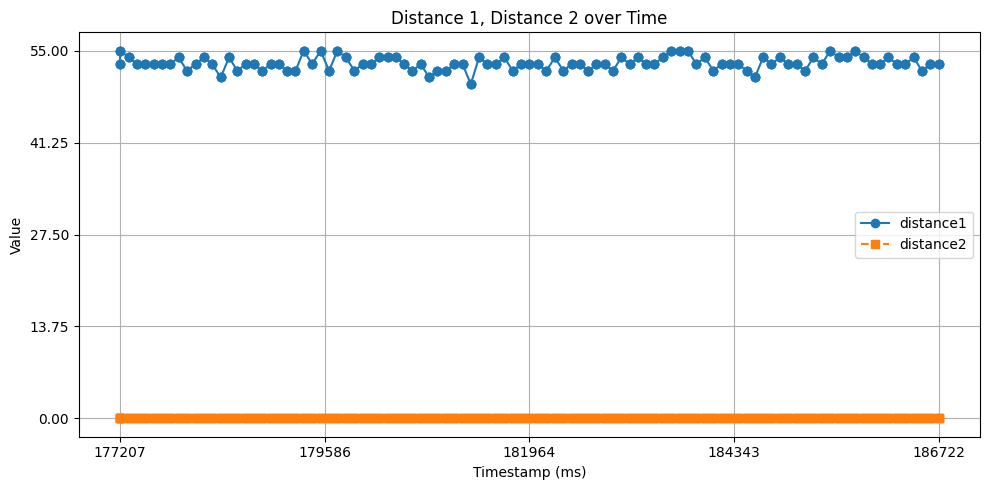

In [9]:
# Cast to correct data type
tof_timestamps = np.array(tof_timestamps, dtype=int)  
distance1 = np.array(distance1, dtype=int)      
distance2 = np.array(distance2, dtype=int)      

plt.figure(figsize=(10, 5))  # Set figure size

# Define how many ticks you want
num_ticks = 5  # Adjust for spacing

# Plot all three lines on the same graph
plt.plot(tof_timestamps, distance1, label='distance1', linestyle='-', marker='o')
plt.plot(tof_timestamps, distance2, label='distance2', linestyle='--', marker='s')

# Labels and title
plt.xlabel('Timestamp (ms)')
plt.ylabel('Value')
plt.title('Distance 1, Distance 2 over Time')
plt.legend()

# Reduce the number of ticks on x and y axes
plt.xticks(np.linspace(tof_timestamps.min(), tof_timestamps.max(), num_ticks))
plt.yticks(np.linspace(min(distance1.min(), distance2.min()), 
                       max(distance1.max(), distance2.max()), num_ticks))

plt.grid(True)  # Add grid for readability
plt.tight_layout()
plt.show()

Calculate Average Distance, Ranging Time, Standard deviation

In [11]:
distance1_avg = np.mean(distance1)
average_diff_ms = np.mean(np.diff(tof_timestamps))
std_dev = np.std(distance1)

print(f"distance1 avg: {distance1_avg}")
print(f"ranging time: {average_diff_ms}")
print(f"Standard Deviation: {std_dev:.4f}")


distance1 avg: 3111.79
ranging time: 95.18181818181819
Standard Deviation: 3.7021
2025-02-24 23:53:00,176 | INFO     |: Disconnected from C0:81:80:25:12:64


Plotting distance, ranging time, std dev

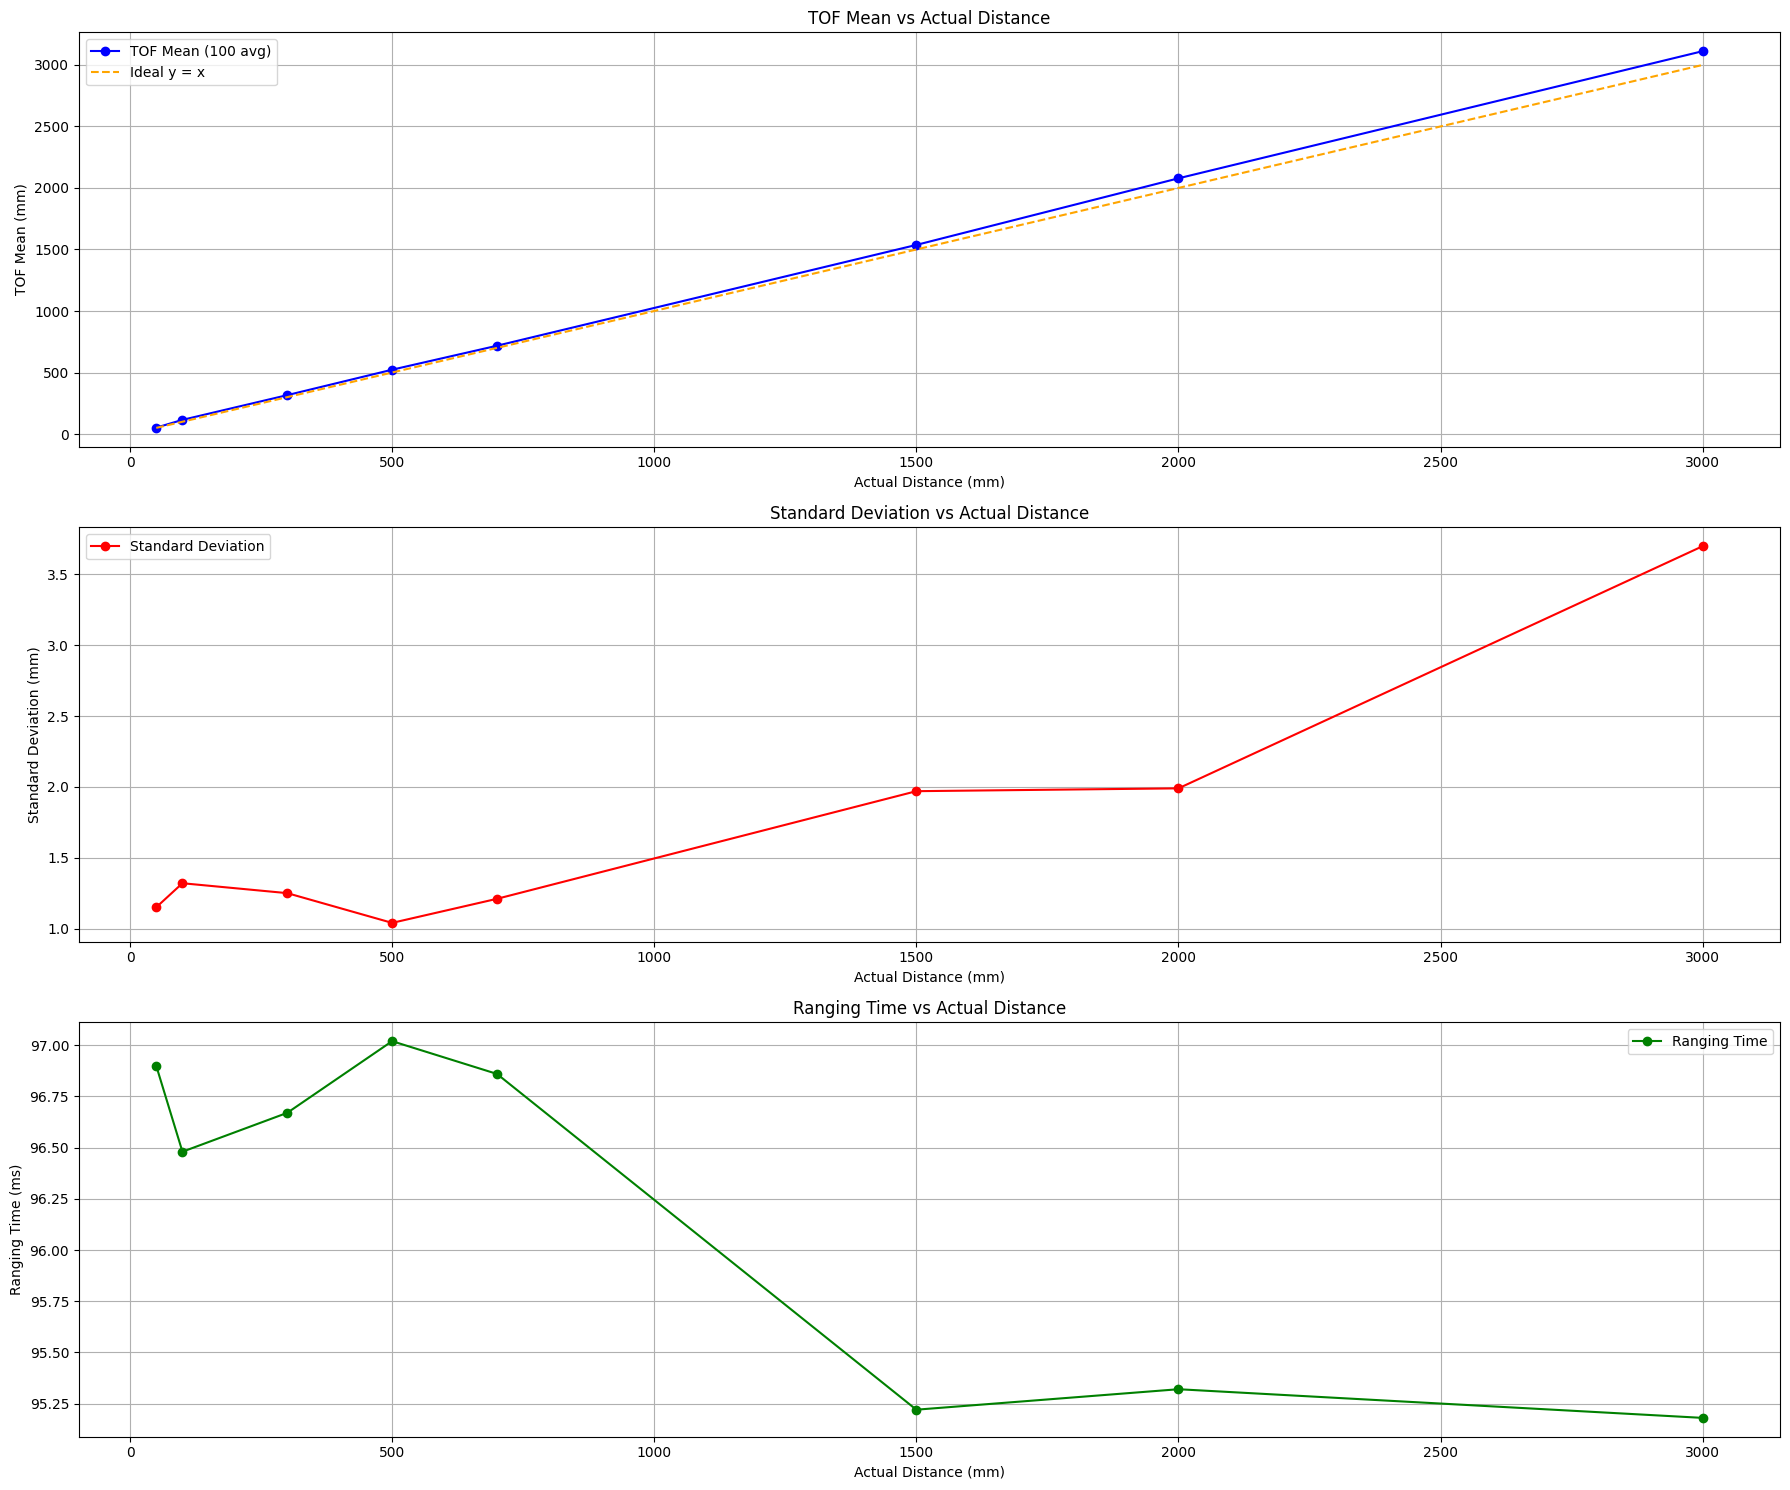

In [14]:
# Data from the table
actual_distance = np.array([50, 100, 300, 500, 700, 1500, 2000, 3000])  # in mm
tof_mean = np.array([52.0, 115.11, 316.18, 522.89, 717.57, 1537.04, 2078.4, 3111.79])  # short distance (100 avg)
ranging_time = np.array([96.90, 96.48, 96.67, 97.02, 96.86, 95.22, 95.32, 95.18])  # in ms
std_deviation = np.array([1.15, 1.32, 1.25, 1.04, 1.21, 1.97, 1.99, 3.70])  # in mm

# Create subplots
plt.figure(figsize=(18, 15))

# Plot 1: TOF Mean with y = x line
plt.subplot(3, 1, 1)
plt.plot(actual_distance, tof_mean, marker='o', color='b', label='TOF Mean (100 avg)')
plt.plot(actual_distance, actual_distance, linestyle='--', color='orange', label='Ideal y = x')
plt.xlabel('Actual Distance (mm)')
plt.ylabel('TOF Mean (mm)')
plt.title('TOF Mean vs Actual Distance')
plt.grid(True)
plt.legend()

# Plot 2: Standard Deviation
plt.subplot(3, 1, 2)
plt.plot(actual_distance, std_deviation, marker='o', color='r', label='Standard Deviation')
plt.xlabel('Actual Distance (mm)')
plt.ylabel('Standard Deviation (mm)')
plt.title('Standard Deviation vs Actual Distance')
plt.grid(True)
plt.legend()

# Plot 3: Ranging Time
plt.subplot(3, 1, 3)
plt.plot(actual_distance, ranging_time, marker='o', color='g', label='Ranging Time')
plt.xlabel('Actual Distance (mm)')
plt.ylabel('Ranging Time (ms)')
plt.title('Ranging Time vs Actual Distance')
plt.grid(True)
plt.legend()

# Display plots
plt.tight_layout()
plt.show()

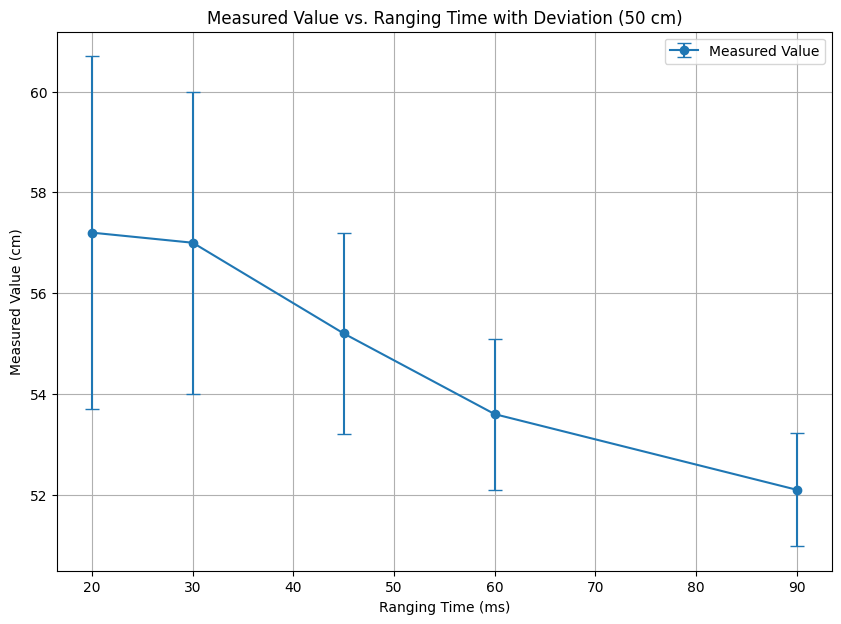

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for 50 cm measurements
ranging_time = np.array([20, 30, 45, 60, 90])  # Ranging times in milliseconds
measured_values = np.array([57.2, 57.0, 55.2, 53.6, 52.1])  # Example measured values in cm
std_deviation = np.array([3.5, 3.0, 2.0, 1.5, 1.12])  # Standard deviation for each measurement

# Create the plot
plt.figure(figsize=(10, 7))
plt.errorbar(ranging_time, measured_values, yerr=std_deviation, fmt='o-', capsize=5, label='Measured Value')

# Plot formatting
plt.title('Measured Value vs. Ranging Time with Deviation (50 cm)')
plt.xlabel('Ranging Time (ms)')
plt.ylabel('Measured Value (cm)')
plt.legend()
plt.grid(True)
plt.show()


In [818]:
control_timestamps = []
i_err = []
p_err = []
speed = []
distance = []
dt = []

tof_available = []

def extract_control_data(uuid, byte_array):
    string = byte_array.decode("utf-8") 
    split_str = string.split("|")
    control_timestamps.append(int(split_str[0]))
    speed.append(int(split_str[1]))
    p_err.append(int(split_str[2]))
    i_err.append(int(split_str[3]))
    distance.append(int(split_str[4]))
    dt.append(int(split_str[5]))
    tof_available.append(int(split_str[6]))
    
ble.start_notify(ble.uuid['RX_STRING'], extract_control_data)

In [820]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [559]:
ble.send_command(CMD.FORWARD_CONTROLLED, "0.1|0.00001|60|300|20|20000")

In [822]:
ble.send_command(CMD.FORWARD_EXTRAPOLATE, "0.1|0.00001|80|360|20|10000")

In [568]:
ble.send_command(CMD.FORWARD, "140|110")

In [560]:
ble.send_command(CMD.BACKWARD, "200")

In [560]:
ble.send_command(CMD.STOP, "")

In [806]:
print("timestamps:")
print(control_timestamps)
print("speed:")
print(speed)
print("p err:")
print(p_err)
print("i err:")
print(i_err)
print("distance")
print(distance)
print("data available:")
print(tof_available)
print("dt: ")
print(dt)




timestamps:
[1805138, 1822167, 1822167, 1822310, 1822310, 1822328, 1822328, 1822337, 1822337, 1822348, 1822348, 1822359, 1822359, 1822373, 1822373, 1822384, 1822384, 1822400, 1822400, 1822406, 1822406, 1822417, 1822417, 1822422, 1822422, 1822433, 1822433, 1822439, 1822439, 1822449, 1822449, 1822455, 1822455, 1822466, 1822466, 1822471, 1822471, 1822479, 1822479, 1822490, 1822490, 1822495, 1822495, 1822505, 1822505, 1822516, 1822516, 1822521, 1822521, 1822527, 1822527, 1822538, 1822538, 1822548, 1822548, 1822559, 1822559, 1822569, 1822569, 1822580, 1822580, 1822591, 1822591, 1822608, 1822608, 1822619, 1822619, 1822630, 1822630, 1822635, 1822635, 1822646, 1822646, 1822660, 1822660, 1822671, 1822671, 1822687, 1822687, 1822697, 1822697, 1822708, 1822708, 1822715, 1822715, 1822726, 1822726, 1822736, 1822736, 1822752, 1822752, 1822763, 1822763, 1822774, 1822774, 1822785, 1822785, 1822796, 1822796, 1822807, 1822807, 1822818, 1822818, 1822823, 1822823, 1822834, 1822834, 1822839, 1822839, 182285

In [808]:
import csv
# Define the CSV filename
filename = "sensor_data.csv"

# Save to CSV
with open(filename, mode="w", newline="") as file:
    writer = csv.writer(file)
    
    # Write the header
    writer.writerow(["Timestamps", "Speed", "P Error", "I Error", "Distance", "Data Available", "dt"])
    
    # Write the data rows
    for i in range(len(control_timestamps)):  # Assuming all lists have the same length
        writer.writerow([
            control_timestamps[i], 
            speed[i], 
            p_err[i], 
            i_err[i], 
            distance[i], 
            tof_available[i], 
            dt[i]
        ])

print(f"Data saved to {filename} successfully!")

IndexError: list index out of range

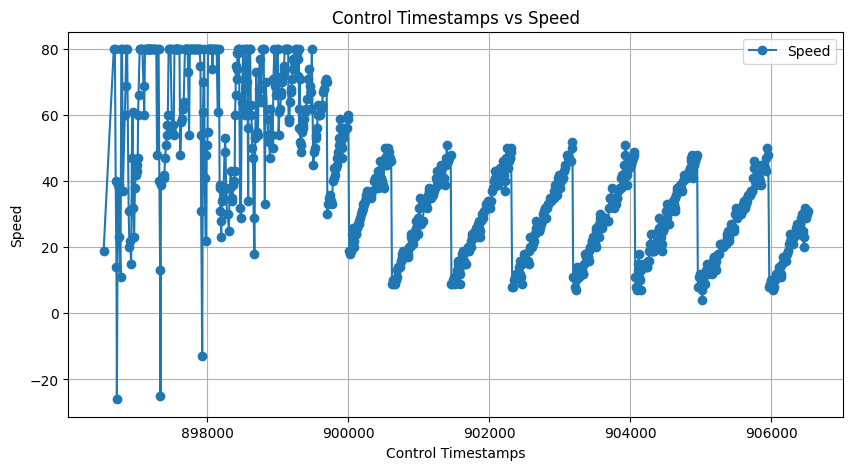

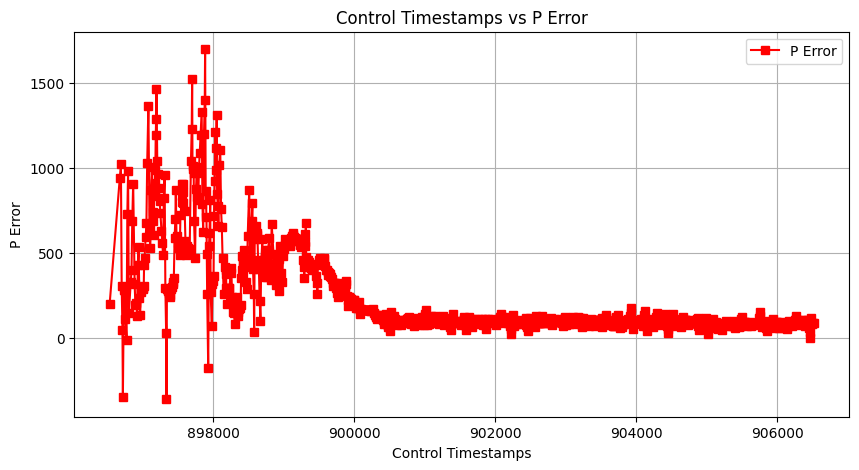

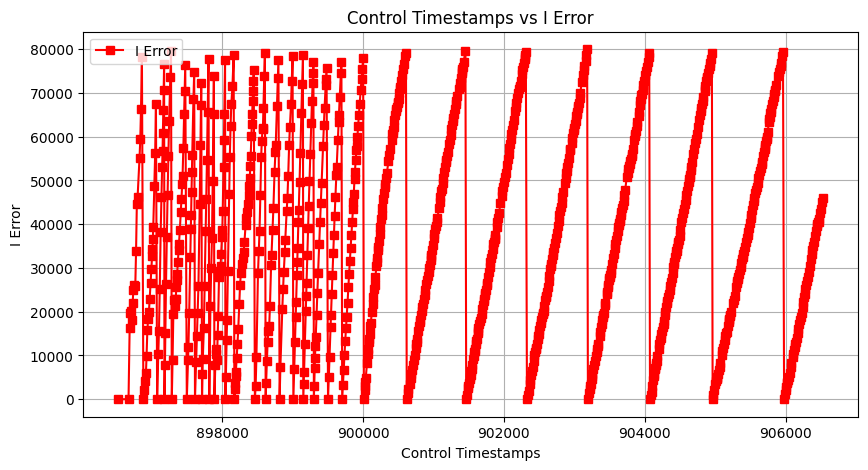

In [797]:
import matplotlib.pyplot as plt
import numpy as np

# Convert lists to numpy arrays for better performance
control_timestamps = np.array(control_timestamps)
speed = np.array(speed)
p_err = np.array(p_err)
i_err = np.array(i_err)

# Plot control timestamps vs. speed
plt.figure(figsize=(10, 5))
plt.plot(control_timestamps, speed, marker='o', linestyle='-', label='Speed')
plt.xlabel('Control Timestamps')
plt.ylabel('Speed')
plt.title('Control Timestamps vs Speed')
plt.legend()
plt.grid(True)
plt.show()

# Plot control timestamps vs. p_err
plt.figure(figsize=(10, 5))
plt.plot(control_timestamps, p_err, marker='s', linestyle='-', label='P Error', color='r')
plt.xlabel('Control Timestamps')
plt.ylabel('P Error')
plt.title('Control Timestamps vs P Error')
plt.legend()
plt.grid(True)
plt.show()

# Plot control timestamps vs. i_err
plt.figure(figsize=(10, 5))
plt.plot(control_timestamps, i_err, marker='s', linestyle='-', label='I Error', color='r')
plt.xlabel('Control Timestamps')
plt.ylabel('I Error')
plt.title('Control Timestamps vs I Error')
plt.legend()
plt.grid(True)
plt.show()


In [431]:
print(p_err)

[350, 363, 331, 366, 349, 390, 382, 347, 360, 382, 343, 359, 401, 335, 364, 371, 373, 372, 421, 392, 375, 408, 436, 441, 449, 468, 475, 505, 532, 523, 586, 588, 582, 643, 540, 519, 542, 365, 391, 267, 319, 276, 294, 280, 286, 278, 296, 265, 263, 268, 265, 240, 242, 235, 239, 231, 224, 215, 165, 169, 175, 163, 157, 162, 162, 151, 150, 151, 147, 145, 147, 138, 145, 141, 135, 140, 146, 148, 161, 161, 167, 169, 169, 167, 184, 188, 188, 186, 190, 189, 205, 211, 239, 277, 293, 413, 599, 649, 674, 677, 687, 697, 703, 694, 706, 712, 709, 709, 715, 734, 721, 710, 719, 703, 706, 692, 671, 655, 647, 654, 645, 623, 569, 493, 501, 494, 358, 278, 232, 194, 127, 88]


In [363]:
print(i_err)

[652, 17206, 48265, 110217, 177225, 242555, 307047, 375141, 441166, 507999, 567339, 632105, 690917, 756197, 820832, 881634, 946074, 1007844, 1073455, 1138499, 1197829, 1257933, 1319904, 1384409, 1445405, 1503530, 1550188, 1595080, 1635575, 1670819, 1702769, 1731160, 1757504, 1782408, 1805376, 1826720, 1845878, 1862531, 1877637, 1890832, 1901620, 1910728, 1919009, 1927265, 1935435, 1942579, 1948903, 1954423, 1959246, 1963852, 1968544, 1972930, 1977634, 1981726, 1985315, 1987947, 1990851, 1994157, 1996649, 1998696, 2000670, 2002455, 2003879]
